In [54]:
%matplotlib inline

In [55]:
%run ./setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# notebook specific imports
import pickle
import copy
import utils.utils_funcs as utils
import math
from subsets_analysis import Subsets
from scipy import signal
import random
import more_itertools as mit
from scipy.ndimage import gaussian_filter

In [57]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

In [58]:
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

In [59]:
pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/'

runs = []
for mouse in run_dict:
    for run_number in run_dict[mouse]:
        run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
        with open(run_path, 'rb') as f:
            r = pickle.load(f)
            runs.append(r)

In [60]:
# how many frames before and after the onset of lick trial to include in the kernal
pre_frames  = 5
post_frames = 9
fs = 5  # frame rate / plane

# empirally observed that 1.4 seconds after onset the artifact has gone for 150 cell trials
# offset = math.ceil(1.4*fs)

# empirally observed that offset = 4 for non-150 cell stims
offset = 4

n_sessions = len(runs)
np.mean = np.nanmean  # lots of nans to deal with here

offset

4

In [61]:
def filter_unhealthy_cells(run):
    max_cell = np.max(run.flu, 1)
    min_cell = np.min(run.flu, 1)
    healthy = np.where((max_cell<5)&(min_cell>-5))[0]
    run.flu = run.flu[healthy,:]
    run.frames_ms = run.frames_ms[healthy,:]
    run.frames_ms_pre = run.frames_ms_pre[healthy,:]
    run.stat = run.stat[healthy]
    return run

In [62]:
def select_s2(run):
    
    '''n.b. currently only works for three plane imaging sessions'''
    
    s2_cells = []
    for i,s in enumerate(run.stat):
        if s['iplane'] == 0 and s['med'][1] > 512:
            s2_cells.append(i)
        elif s['iplane'] == 1 and s['med'][1] > 1536:
            s2_cells.append(i)
        elif s['iplane'] == 2 and s['med'][1] > 512:
            s2_cells.append(i)
        
        
    run.flu = run.flu[s2_cells,:]
    run.frames_ms = run.frames_ms[s2_cells,:]
    run.frames_ms_pre = run.frames_ms_pre[s2_cells,:]
    run.stat = run.stat[s2_cells]
    
    return run

In [63]:
def prepost_diff(array_list, pre_frames=10, post_frames=50, offset=0, filter_list=None):
    
    n_sessions = len(array_list)
    
    if filter_list:
        array_list = [array_list[i][:,filter_list[i],:] for i in range(n_sessions)]
    
    session_average, _, _, cell_average = utils.averager(array_list, pre_frames, post_frames)

    return np.mean(session_average[:, pre_frames+offset:pre_frames+offset+(post_frames-offset)], 1) -\
           np.mean(session_average[:, 0:pre_frames], 1)

In [64]:
def good_trials(run, window_size=5, plot=False):

    subsets = Subsets(run)
    
    easy_idx = np.where(subsets.trial_subsets==150)[0]
    nogo_idx = np.where(subsets.trial_subsets==0)[0]

    go_outcome = []
    nogo_outcome = []

    for trial in run.outcome[easy_idx]:
        if trial == 'hit':
            go_outcome.append(1)
        elif trial == 'miss':
            go_outcome.append(0)
        else:
            raise ValueError

    for trial in run.outcome[nogo_idx]:
        if trial == 'fp':
            nogo_outcome.append(1)
        elif trial == 'cr':
            nogo_outcome.append(0)
        else:
            raise ValueError

    running_go = np.convolve(go_outcome, np.ones((window_size,))/window_size, mode='valid')
    running_nogo = np.convolve(nogo_outcome, np.ones((window_size,))/window_size, mode='valid')
    
    # resample the nogo so lengths are matched
    if len(running_nogo) != len(running_go):
        running_nogo = signal.resample(running_nogo, len(running_go))

    assert len(running_go) == len(running_nogo)
    
    running_dp = [utils.d_prime(go, nogo) for go, nogo in zip(running_go, running_nogo)]
    running_dp = signal.resample(running_dp, len(easy_idx))
        
    x_coords = np.delete(np.arange(len(run.outcome)), easy_idx)
    dp_interped = np.interp(x_coords, easy_idx, running_dp)
    
    if plot:
        plt.plot(dp_interped)
        plt.plot(np.linspace(0, len(dp_interped), len(running_go)), running_go, color='red')
        plt.plot(np.linspace(0, len(dp_interped), len(running_nogo)), running_nogo, color='green')
        
    return np.where(dp_interped >= 1)[0]

In [65]:
def get_time_to_lick(run, fs=5):
    
    n_trials = len(run.outcome)

    time_to_lick = []

    # inter_frame_interval in ms
    ifi_ms = 1000 / fs
    for b in run.binned_licks_easytest:
        if len(b) == 0:
            time_to_lick.append(np.nan)
        else:
            time_to_lick.append(math.floor(b[0] / ifi_ms))
            
    return np.array(time_to_lick)

In [66]:
def subtract_kernal(flu_array, run, trials_to_sub='all', 
                    offset_sub=None, pre_frames=10, post_frames=50, plot=False):

    if trials_to_sub == 'all':
        trials_to_sub = np.arange(flu_array.shape[1])
        
    if offset_sub is None:
        offset_sub = np.repeat(0, flu_array.shape[1])
    
    assert flu_array.shape[1] == len(offset_sub)

    # get lick kernal for all time_to_lick offsets
    kernals = []
    for offset in np.arange(np.max(offset_sub[trials_to_sub])+1):
        offset = int(offset)
        kernals.append(utils.build_flu_array(run, run.pre_reward, 
                       pre_frames+offset, post_frames-offset, True))
        
    # mean across trials [n_cells x pre_frames+post_frames]
    mean_kernals = [np.mean(kernal, 1) for kernal in kernals]
    # type error with nans here means trials are misaligned
    offset_sub[trials_to_sub]
    
    pre_post = np.mean(mean_kernals[0][:,pre_frames:post_frames], 1) - np.mean(mean_kernals[0][:,0:pre_frames], 1)
    cell_licky_idx = np.flip(np.argsort(pre_post))
    
    if plot:  
        fig = plt.figure(figsize=(22,8))
        x_axis = np.arange(pre_frames+post_frames)
        for i, cell in enumerate(cell_licky_idx[:12]):
            plt.subplot(3,4,i+1)
            plt.plot(x_axis, np.mean(flu_array[cell, :, :], 0), 'blue', label='Mean Hit Trials')
            plt.plot(x_axis, mean_kernals[0][cell, :], 'green', label='Lick Kernal')
            plt.plot(x_axis, np.mean(flu_array[cell, :, :], 0) - mean_kernals[offset][cell, :], 'pink', label='Kernal subtracted')
            plt.xticks(x_axis)
        handles, labels = plt.gca().get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center')

    for i,t in enumerate(trials_to_sub):
        offset = int(offset_sub[t])
        mean_kernal = mean_kernals[offset]

        flu_array[:, t, :] = flu_array[:, t, :] - mean_kernal
        
    return flu_array, cell_licky_idx, pre_post

In [67]:
runs = [filter_unhealthy_cells(run) for run in runs]
runs = [select_s2(run) for run in runs]
runs = [utils.lick_binner(run) for run in runs]

In [68]:
behaviour_list = [utils.build_flu_array(run, run.trial_start, pre_frames, post_frames) for run in runs]

hit_list = [np.where(run.outcome=='hit')[0] for run in runs]

subtraction_res = [subtract_kernal(behaviour_list[session], runs[session], 
                                  hit_list[session], get_time_to_lick(runs[session]),
                                  pre_frames=pre_frames, post_frames=post_frames) 
                   for session in range(n_sessions)]

#behaviour_list =  [res[0] for res in subtraction_res]
print('Warning: disabled subtraction')
cell_licky_idxs = [res[1] for res in subtraction_res]
licky_pre_posts = [res[2] for res in subtraction_res]

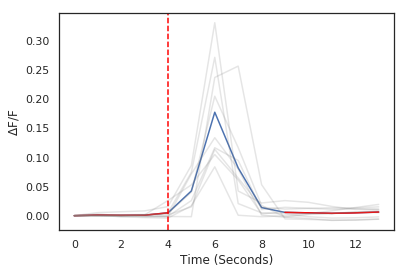

In [16]:
# plot the average traces for go trials without easy stim
test_filter = [np.where((Subsets(run).trial_subsets != 150)&(Subsets(run).trial_subsets!=0))[0]
               for run in runs]

_,_,_,_ = utils.averager(behaviour_list, pre_frames=pre_frames, post_frames=post_frames, 
                 trial_filter=test_filter, offset=offset, plot=True)

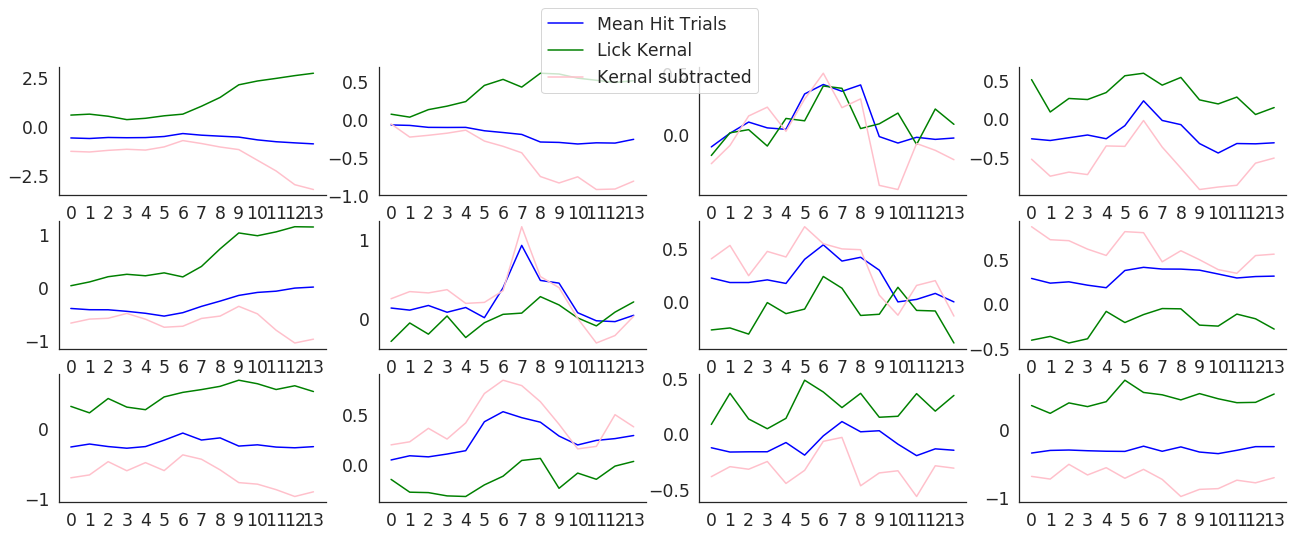

In [69]:
# some examples of subtraction
session_idx = 0
flu_array = copy.deepcopy(behaviour_list[session_idx])
run = copy.deepcopy(runs[session_idx])

intersect = lambda lst1, lst2: list(set(lst1) & set(lst2)) 
hit_trials = copy.deepcopy(hit_list[session_idx])
sub_trials = np.where(Subsets(run).trial_subsets==50)[0]

# sub_trials = hit_trials
trials_to_sub = intersect(hit_trials, sub_trials)
offset_sub = get_time_to_lick(run)

subtraction_res = subtract_kernal(flu_array, run, trials_to_sub, offset_sub, pre_frames=pre_frames,
                                  post_frames=post_frames, plot=True)

(0, 2000)

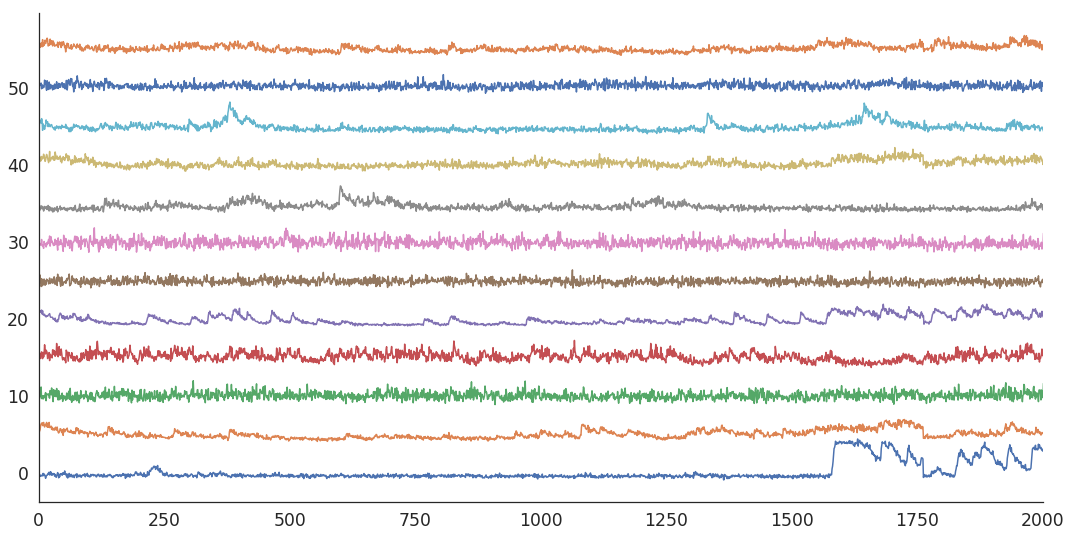

In [70]:
run = runs[session_idx]
plt.figure(figsize=(18,9))
for i, cell in enumerate(cell_licky_idxs[session_idx][:12]): 
    plt.plot(run.flu[cell, :] + i*5)
plt.xlim((0,2000))

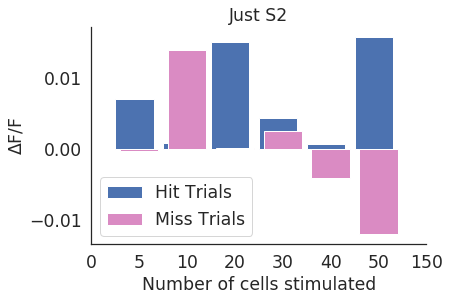

In [71]:
intersect = lambda lst1, lst2: list(set(lst1) & set(lst2)) 

subset_sizes = np.unique(Subsets(runs[0]).trial_subsets)

hit_diffs = []
miss_diffs = []

for i, sub in enumerate(subset_sizes):
    
    if sub == 0 or sub==150:
        continue
        
    hit_trials =  [intersect(np.where((run.outcome=='hit') & (Subsets(run).trial_subsets==sub))[0],
                             good_trials(run))
                             for run in runs]
    
    miss_trials =  [intersect(np.where((run.outcome=='miss') & (Subsets(run).trial_subsets==sub))[0],
                             good_trials(run))
                             for run in runs]

    hit_diff = prepost_diff(behaviour_list, pre_frames=pre_frames, post_frames=post_frames, 
                            offset=offset, filter_list=hit_trials)
    
    miss_diff = prepost_diff(behaviour_list, pre_frames=pre_frames, post_frames=post_frames, 
                             offset=offset, filter_list=miss_trials)
    
    # hit_diff = hit_diff - lick_diff
       
    if i == 1:
        plt.bar(i-0.1, np.mean(hit_diff), color=sns.color_palette()[0], label='Hit Trials')
        plt.bar(i, np.mean(miss_diff), color=sns.color_palette()[6], label='Miss Trials')
    else:
        plt.bar(i-0.1, np.mean(hit_diff), color=sns.color_palette()[0])
        plt.bar(i, np.mean(miss_diff), color=sns.color_palette()[6])
    
    hit_diffs.append(hit_diff)
    miss_diffs.append(miss_diff)
    
plt.legend()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Number of cells stimulated')
sns.despine()
plt.xticks(range(len(subset_sizes)), subset_sizes)
plt.title('Just S2')

hit_diffs = np.array(hit_diffs)
miss_diffs = np.array(miss_diffs)

In [72]:
# which cells contribute most the above plot?
hit_trials =  [intersect(np.where((run.outcome=='hit') & (Subsets(run).trial_subsets!=150))[0],
                         good_trials(run))
               for run in runs]

miss_trials =  [intersect(np.where((run.outcome=='miss') & (Subsets(run).trial_subsets!=150))[0],
                         good_trials(run))
               for run in runs]

_,_,_, hit_averages = utils.averager(behaviour_list, pre_frames=pre_frames, post_frames=post_frames,
                              offset=offset, trial_filter=hit_trials)
    
_,_,_, miss_averages = utils.averager(behaviour_list, pre_frames=pre_frames, post_frames=post_frames,
                              offset=offset, trial_filter=miss_trials)
    
cell_differ = lambda cell_average:  (np.mean(cell_average[:, pre_frames+offset:
                                            pre_frames+offset+(post_frames-offset)], 1) -
                                    np.mean(cell_average[:, 0:pre_frames], 1))


diffy_hit = [cell_differ(c) for c in hit_averages]
diffy_miss = [cell_differ(c) for c in miss_averages]
diffest = np.argsort(diffy_hit[0])[-12:]
diffest

array([360, 368, 663, 625, 673, 410,  41, 800, 302, 600, 151, 611])

In [73]:
# plt.figure(figsize=(25,8))
# for i, cell in enumerate(diffest):
#     plt.subplot(3,4,i+1)
#     plt.plot(cell_averages[0][cell,:])
#     plt.xticks(np.arange(pre_frames+post_frames))
#     plt.ylim((-1,1))

In [79]:
all_hittys = np.concatenate(diffy_hit).ravel()
all_missys = np.concatenate(diffy_miss).ravel()
all_lickys = np.concatenate(licky_pre_posts).ravel()
double_diffy = all_hittys - all_missys
# toggle this line to compare just hit trials to lickys
# double_diffy = all_hittys
assert all_lickys.shape == double_diffy.shape

nonnan_idx = np.logical_and(~np.isnan(double_diffy), ~np.isnan(all_lickys))

x = double_diffy[nonnan_idx].reshape(-1, 1)
y = all_lickys[nonnan_idx]

model = LinearRegression()
model.fit(x,y)
r_sq = r2_score(x, model.predict(x))
r_sq

-0.3565218688009024

Text(0.5, 0.5, 'r^2 = -0.357')

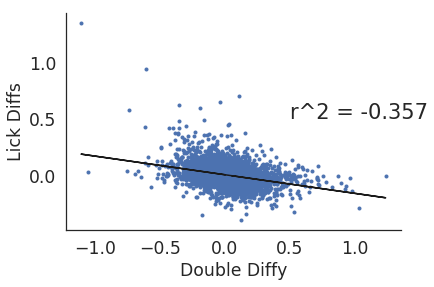

In [80]:
plt.plot(double_diffy, all_lickys, '.')
plt.xlabel('Double Diffy')
plt.ylabel('Lick Diffs')
plt.plot(x, model.predict(x), color='k')
plt.text(0.5, 0.5, 'r^2 = {}'.format(round(r_sq, 3)), fontsize=21)

Text(0.5, 0, 'Lick Diff')

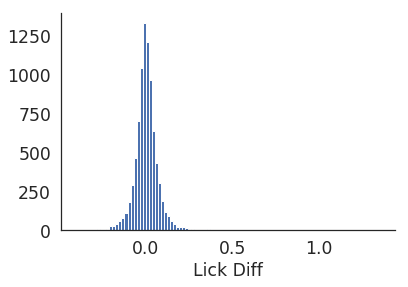

In [81]:
h = plt.hist(y, bins=100)
cur_axes = plt.gca()
#cur_axes.axes.get_yaxis().set_visible(False)
plt.xlabel('Lick Diff')
#plt.ylim(0,30)

In [82]:
# how many licks on pre_reward vs hit_rewards???
# bin the pre-licks
pre_binnedlicks = []

for run in runs:
    tstarts = run.pre_reward
    pre_licks = run.pre_licks

    for i, tstart in enumerate(tstarts):
        if i == len(tstarts) - 1:
            tend = np.inf
        else:
            tend = tstarts[i+1]

        lick_idx = np.where((run.pre_licks >= tstart) & (run.pre_licks < tend))

        pre_binnedlicks.append(pre_licks[lick_idx])

# the number of licks in each trial
pre_nlicks = np.array([len(binned) for binned in pre_binnedlicks])

In [83]:
# flat list of binned licks
binned_licks = []
for run in runs:
    for trial, outcome in enumerate(run.outcome):
        if outcome=='hit':
            binned_licks.append(run.binned_licks[trial])
    
n_licks = np.array([len(binned) for binned in binned_licks])


([<matplotlib.axis.XTick at 0x7f7297135588>,
 <a list of 2 Text xticklabel objects>)

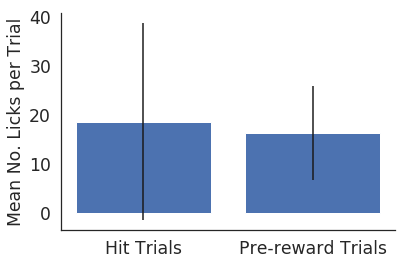

In [84]:
plt.bar([0,1], [n_licks.mean(), pre_nlicks.mean()], yerr=[n_licks.std(), pre_nlicks.std()])
plt.ylabel('Mean No. Licks per Trial')
plt.xticks([0,1],['Hit Trials', 'Pre-reward Trials'])

In [135]:
1/0

ZeroDivisionError: division by zero

## Lick trial classification using LSTMs

In [ ]:
## subtraction of the pre-reward trials for classifier

lick_kernals = [utils.build_flu_array(run, run.pre_reward, pre_frames, post_frames, True)
                for run in runs]

subtraction_res = [subtract_kernal(lick_kernals[session], runs[session],
                                  pre_frames=pre_frames, post_frames=post_frames) 
                   for session in range(n_sessions)]

lick_kernals_subbed = [res[0] for res in subtraction_res]

In [ ]:
def build_session_array(list_, filter_list=None, n_filtered_cells=None):
    
    ''' builds a tbt flu array across sessions from list of inidivudual sessions
        Returns:
        session_array -- [min cells x total trials x frames in trial]
    
        '''
    min_cells = min([s.shape[0] for s in list_])
    
    if filter_list:
        assert len(filter_list) == len(list_) and n_filtered_cells != None\
        and n_filtered_cells <= min_cells

    for i, arr in enumerate(list_):
        if filter_list:
            cell_idxs = filter_list[i][0:n_filtered_cells]
        else:     
            # randomly subsample cells
            cell_idxs = np.random.choice(np.arange(0,arr.shape[0]), min_cells)
        if i == 0:
            session_array = arr[cell_idxs, :, :]
        else:
            session_array = np.hstack((session_array, arr[cell_idxs, : ,:]))

    return session_array

In [ ]:
def get_spont_trials(run):

    # first non-nan frame signifying start of behaviour (-1 in case different cells)
    idx_first = min(np.where(~np.isnan(run.frames_ms[0,:]))[0]) - 1

    # frames that were not in the prereward phase
    non_pre = np.where(np.isnan(run.frames_ms_pre[0,:]))[0]

    assert max(non_pre) == run.flu.shape[1] - 1
    spont_frames = non_pre[non_pre<idx_first]

    spont_flu = run.flu[:, spont_frames]

    # make a tbt array of 10 spontaneous flu 'trials'
    len_trial = pre_frames + post_frames
    n_trials = 10

    spont_trials = []

    for i in range(n_trials):
        t_start = random.choice(np.arange(len_trial, spont_flu.shape[1] - len_trial))
        trial = spont_flu[:, t_start:t_start+len_trial]
        spont_trials.append(trial)

    return np.swapaxes(np.array(spont_trials), 0, 1)

In [ ]:
def get_LSTM(data_shape):
    
    model = Sequential()
    model.add(LSTM(256, input_shape=(data_shape[1], data_shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    adam = Adam(lr=0.001)

    model.my_checkpoints = ModelCheckpoint('best_model.pkl', monitor='val_acc', 
                                            save_best_only=True, mode='max', verbose=1)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [ ]:
def cv_classifier(arr1, arr2, fold=10, shuffle=False):
    
    assert arr1.shape == arr2.shape
    
    nonnan_trials = lambda arr: ~np.isnan(arr).any(axis=0).any(axis=1)
    nonnan_idx = np.logical_and(nonnan_trials(arr1), nonnan_trials(arr2))
    
    arr1 = arr1[:,nonnan_idx,:]
    arr2 = arr2[:,nonnan_idx,:]
    
    data = np.hstack((arr1, arr2))
    # switch from [n_cells x n_trials x n_frames] to [n_features x n_samples x n_observers]
    data = np.swapaxes(data, 0, 1)   
    
    if shuffle: np.random.shuffle(data)
        
    labels = np.hstack((np.repeat(1, data.shape[0] / 2), np.repeat(0, data.shape[0] / 2)))
    
    kf = ShuffleSplit(n_splits=fold, test_size=0.2)
    test_accs = []
    fold_count = 0
    for train_idx, testvalid_idx in kf.split(data):
        
        half = math.floor(len(testvalid_idx)/2)
        valid_idx = testvalid_idx[:half]
        test_idx = testvalid_idx[half:]
        
        model = get_LSTM(data.shape)
        
        model.fit(data[train_idx], labels[train_idx], epochs=150, batch_size=128, 
                  callbacks=[model.my_checkpoints], 
                  validation_data=(data[valid_idx],labels[valid_idx]),
                  verbose=False)

        test_preds = model.predict_classes(data[test_idx])
        test_accuracy = accuracy_score(labels[test_idx], test_preds)
        print('Test Accuracy is {}'.format(test_accuracy))
        test_accs.append(test_accuracy)
        
        fold_count += 1
        print(fold_count)
        
    return test_accs

In [ ]:
n_cells_keep = 500
spont_list = [get_spont_trials(run) for run in runs]
spont_list2 = [get_spont_trials(run) for run in runs]

spont_arr = build_session_array(spont_list, cell_licky_idxs, n_filtered_cells=n_cells_keep)
spont_arr2 = build_session_array(spont_list2, cell_licky_idxs, n_filtered_cells=n_cells_keep)
lick_arr = build_session_array(lick_kernals, cell_licky_idxs,  n_filtered_cells=n_cells_keep)
lick_arr_subbed = build_session_array(lick_kernals_subbed, cell_licky_idxs,  n_filtered_cells=n_cells_keep)

In [ ]:
test_accs = cv_classifier(lick_arr, spont_arr)
print(np.mean(test_accs))
print(np.std(test_accs))

In [ ]:
test_accs2 = cv_classifier(spont_arr2, spont_arr)
print(np.mean(test_accs2))
print(np.std(test_accs2))

In [ ]:
test_accs3 = cv_classifier(lick_arr, spont_arr, shuffle=True)
print(np.mean(test_accs3))
print(np.std(test_accs3))

In [ ]:
test_accs4 = cv_classifier(lick_arr_subbed, spont_arr, shuffle=False)
print(np.mean(test_accs4))
print(np.std(test_accs4))

In [ ]:
x=np.arange(4)
y = [np.mean(d) for d in [test_accs, test_accs4, test_accs2, test_accs3]]
yerr = [np.std(d) for d in [test_accs, test_accs4, test_accs2, test_accs3]]

In [ ]:
plt.bar(x=x+0.4,height=y,yerr=yerr)

xt = plt.xticks(x, 
                [
                    'Lick vs\nSpontaneous',
                    'Lick Subtracted vs\nSpontaneous',
                    'Spontaneous vs\nSpontaneous',
                    'Lick vs\nSpontaneous Shuffled'
                                                    ],
                rotation=60)
plt.ylabel('Classifier Performance\nChance=0.5')


### SVC lick classification
#### Doesn't make sense to do this as observations are not independent

In [ ]:
def split_dataset(dataset, split=0.8, shuffle=True):
    x,y = dataset
    assert x.shape[0] == y.shape[0]
    n_trials = x.shape[0]
    subset = int(split*n_trials)
    idx = np.arange(n_trials)
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:subset]
    x_valid = x[subset:]
    y_train = y[:subset]
    y_valid = y[subset:]
    return (x_train, y_train),(x_valid, y_valid)

In [ ]:
def split_dataset3d(dataset, split=0.8, shuffle=True):
    x,y = dataset
    assert x.shape[1] == y.shape[0]
    n_trials = x.shape[1]
    subset = int(split*n_trials)
    idx = np.arange(n_trials)
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:subset]
    x_valid = x[subset:]
    y_train = y[:subset]
    y_valid = y[subset:]
    return (x_train, y_train),(x_valid, y_valid)

In [ ]:
def split_dataset(dataset, split=0.8, shuffle=True):
    x,y = dataset
    assert x.shape[0] == y.shape[0]
    n_trials = x.shape[0]
    idx = np.arange(n_trials)
    n_trials_train = int(len(idx) * split)
    n_trials_valid = math.ceil((n_trials - n_trials_train) / 2)
    n_trials_test = math.floor((n_trials - n_trials_train)  / 2)

    if shuffle: np.random.shuffle(idx)
    idx_train = idx[:n_trials_train]
    idx_valid = idx[n_trials_train:n_trials_train+n_trials_valid]
    idx_test  = idx[n_trials_train+n_trials_valid:]
    
    return (x[idx_train], y[idx_train]), (x[idx_valid], y[idx_valid]), (x[idx_test], y[idx_test])

In [ ]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

In [ ]:
## cell builds dataset for classifier that is trial averaged

spont_list = [get_spont_trials(run) for run in runs]
spont_list2 = [get_spont_trials(run) for run in runs]
# the number of cells from each session to insert into the array

spont_arr = build_session_array(spont_list, cell_licky_idxs, n_filtered_cells=n_cells_keep)
lick_arr = build_session_array(spont_list2, cell_licky_idxs, n_filtered_cells=n_cells_keep)
#lick_arr = build_session_array(lick_kernals_subbed, cell_licky_idxs,  n_filtered_cells=n_cells_keep)


assert spont_arr.shape == lick_arr.shape

nonnan_idx = ~np.isnan(lick_arr).any(axis=0).any(axis=1)

lick_arr = lick_arr[:,nonnan_idx,:]
spont_arr = spont_arr[:,nonnan_idx,:]

# mean across trials
spont = np.mean(spont_arr, 1)
lick = np.mean(lick_arr, 1)
all_arr = np.hstack((lick, spont)).T
labels = np.hstack((np.repeat(1, all_arr.shape[0] / 2), np.repeat(0, all_arr.shape[0] / 2)))

In [ ]:
training_accs = []
test_accs = []
cvs = []

n_cells_list = np.arange(10,500,10)

for n_cells in n_cells_list:
    x = all_arr[:,0:n_cells]

    dataset = (x, labels)
    
    trainset, validset = split_dataset(dataset)
    scaler = StandardScaler()
    trainset = scaler.fit_transform(trainset[0]), trainset[1]
    validset = scaler.fit_transform(validset[0]), validset[1]
     
    clf = SVC(kernel='poly', C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=3)
    cvs.append(scores.mean())


In [ ]:
plt.plot(n_cells_list, cvs)
plt.xlim((0,200))
plt.xlabel('Number of cells shown to classifier')
plt.ylabel('Classifier Accuracy')
plt.title('Spontaneous vs Spontanous')

In [ ]:
# confusion matrix for the final iteration of the above loop

svc = SVC(kernel='poly')
svc.fit(*trainset)
y_true=validset[1]
y_pred=svc.predict(validset[0])
M=confusion_matrix(y_true, y_pred)
plt.imshow(M)
plt.title("Confusion matrix")
plt.colorbar()